---
# Part 2, Figure 4
Water column presence and depths

---

This code requires output from code run on Compute Canada's HPC. For the purpose of this publication, this code has been placed in `../scripts/HPC_scripts/HPC_aggregate_mass_balance.py`

Package requirements are included in ../environment.yaml.  Install in the upper-level directory using:
```
$ conda env create -f ./environment.yaml
```
                                                                               
To activate this environment, use 
```                  
$ conda activate midoss_env
```
 To deactivate an active environment, use
```
$ conda deactivate
```

Files are loaded from the dataset archive, with both the dataset archive and this code archive in the same folder, i.e.:

- \path\to\root\folder\
   - MuellerEtAl_MIDOSS_datasets
   - MuellerEtAl_MIDOSS_code [this repository]

**Useful information**: 
- this code was developed with `Python 3.6`
- aggregation files were created with [incremental_sums.py](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/blob/main/scripts/Incremental_Sums.py).
- the output from `Incremental_Sums.py` was saved to (and loaded from) `../../MuellerEtAl_MIDOSS_datasets/aggregated_spills_output/`
- a graphics style template in [../graphics_utils](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/blob/publish/graphics_utils) was used.

In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path
import os
from copy import copy
import matplotlib.ticker as ticker
import matplotlib
import scipy.stats as st
import matplotlib.ticker as ticker
import cmocean.cm as cm

# Load aggregated results

In [2]:
# define directory paths
graphics_directory = Path('../')
# Aggregated files path
agg_dir = Path('../../MuellerEtAl_MIDOSS_datasets/aggregated_spills_output/')
# graphics style
plt.style.use(r"../graphics_utils/style.template")
# load aggregated results
oil = xr.open_dataset(agg_dir/f'fiftieth_55_oils.nc')

# Refine graphics

In [3]:
# Define SalishSeaCast grid spacing for plotting x-, y-axis distances
dx=440 # x-grid spacing in m
dy=500 # y-grid spacing in m

# set colormap so it's white (water) and papayawhip (land)
my_cmap = cm.algae 
my_cmap.set_under('w')
my_cmap.set_over('papayawhip')

%matplotlib inline

# Graphic limits
imin = 0
jmin, jmax = 0, 398
imax = imin + (jmax - jmin)*2/500*440
imax = 898
aspect = 500/440

## Load SalishSeaCast grid 

In [4]:
mesh_mask = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV21-08")
tmask = 1- mesh_mask.tmaskutil[0]
divarea = 1/(mesh_mask.e1t[0, 1:-1, 1:-1] * mesh_mask.e2t[0, 1:-1, 1:-1])
alength = 1/np.maximum(mesh_mask.e1t[0, 1:-1:, 1:-1], mesh_mask.e2t[0, 1:-1, 1:-1])
mesh_mask.close()

## Estimate water column presence

In [5]:
ma_deep_pres = np.ma.masked_array(oil.deeppresence, oil.deeppresence == 0)

# Set bounds for calculation. Good if good to 5 m or 25% of depth
absol = 5
perol = 0.25

# noise
eps = 1e-7

# number of spills min_spillsed to be included in quantile calculation
min_spills = 4

ma_deep_location = np.ma.masked_array(oil.deep_location[0]/(oil.deeppresence + eps), 
                                      oil.deeppresence == 0)
print (oil.deep_location.shape)
location_25 = np.quantile(oil.deep_location/(oil.deeppresence + eps), 0.25, axis=0)
location_median = np.quantile(oil.deep_location/(oil.deeppresence + eps), 0.5, axis=0)
location_75 = np.quantile(oil.deep_location/(oil.deeppresence + eps), 0.75, axis=0)

print (location_25.shape)

location = np.ma.masked_array(
    oil.deep_location[0]/(oil.deeppresence + eps), 
    mask = ((oil.deeppresence < min_spills) | (
    (location_75 - location_25 > absol) 
    & (location_75 - location_25 > perol*ma_deep_location)))
)
depth_range = np.ma.masked_array(
    location_75 - location_25, 
    mask = ((oil.deeppresence < min_spills) | (
    (location_75 - location_25 > absol) 
    & (location_75 - location_25 > perol*ma_deep_location)) )
)

print (ma_deep_location.max())

(50, 896, 396)
(896, 396)
279.9262886394291


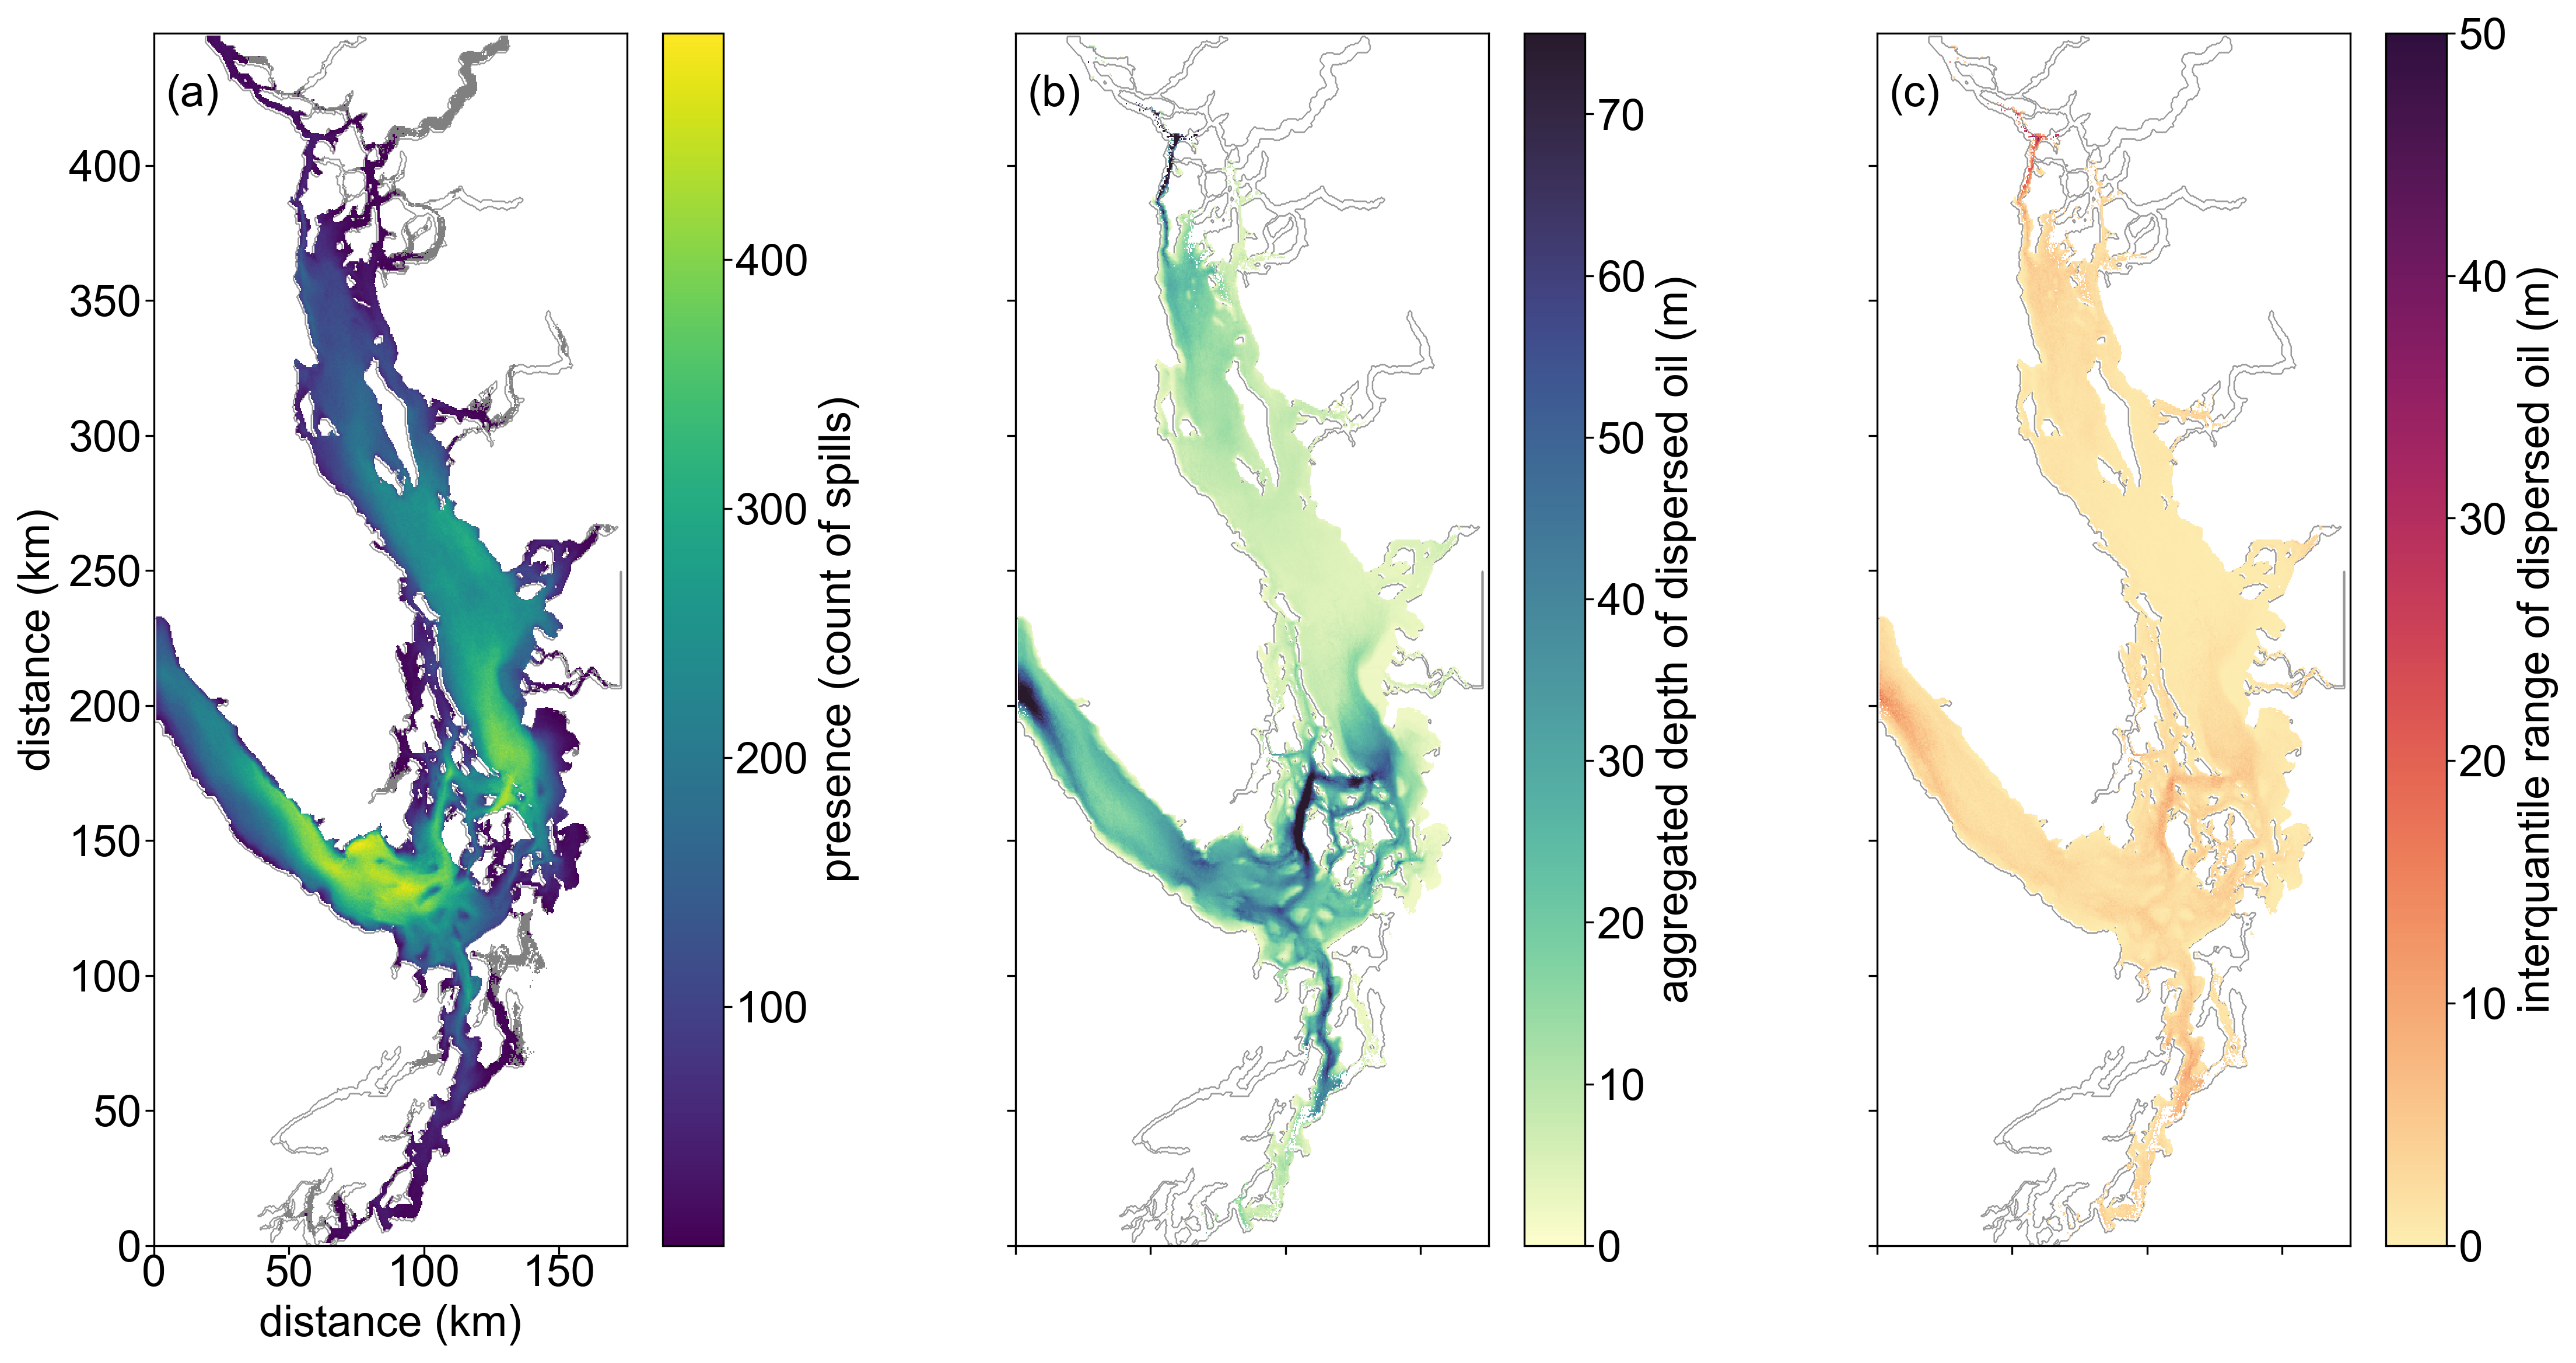

In [6]:
fig, axs = plt.subplots(
    1, 3, 
    figsize=(18, 9), 
    gridspec_kw={'hspace': 0.0}
)

vmin, vmax = 0.01, 50

subplot_labels=['(a)','(b)','(c)']
for idx,ax in enumerate(axs):
    ax.contour(tmask[1:, 1:], linewidths=.2, colors='grey', alpha=.5)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)
    xticks = np.arange(0, 200, 50)/.44
    ax.set_xticks(xticks)
    ax.text(10,imax*0.94,subplot_labels[idx]) 
    if idx != 0:
        ax.set_xticklabels('')
        ax.set_yticklabels('')
    else:
        # convert axis labels to km
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda y, _: '{:g}'.format(dy*y/1000))
        )
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, _: '{:g}'.format(dx*x/1000))
        )
        ax.set_ylabel('distance (km)')
        ax.set_xlabel('distance (km)')
        
axs[0].set_ylabel('distance (km)')

# Number of spills present at depth (min = 4) 
cmap = copy(plt.get_cmap('viridis'))
cmap.set_under('grey')
C = axs[0].pcolormesh(
    np.arange(jmin+1, jmax), 
    np.arange(imin+1, imax), 
    ma_deep_pres, 
    zorder=2, vmin=min_spills, cmap=cmap
)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('presence (count of spills)')

filter_location = copy(location)
filter_location[ma_deep_pres < min_spills] = -1

# average depth of spills
cmap = copy(cm.deep)
cmap.set_under('w')
C = axs[1].pcolormesh(
    np.arange(jmin+1, jmax), 
    np.arange(imin+1, imax),
    filter_location,
    zorder=2, vmin=0, vmax=75, cmap=cmap
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('aggregated depth of dispersed oil (m)')


filter_del = copy(depth_range)
filter_del[ma_deep_pres < min_spills] = -1

cmap = copy(cm.matter)
cmap.set_under('w')
C = axs[2].pcolormesh(
    np.arange(jmin+1, jmax), 
    np.arange(imin+1, imax), 
    filter_del, 
    zorder=2, vmin=0, vmax=50, cmap=cmap,
)
cb = fig.colorbar(C, ax=axs[2]);
cb.set_label('interquantile range of dispersed oil (m)')
fig.savefig('../Part2_Figure4_watercol_presence.png');